In [ ]:
using DataStructures
import ShowGraphviz
using Dates
import Random: randstring

include("src/utils.jl")

abstract type StreamOperation end

# ------------------------------

abstract type CallPolicy end

mutable struct StreamNodeBinding{TNode}
    node::TNode
    call_policies::Vector{CallPolicy}
    function StreamNodeBinding(node::TNode, call_policies::Vector{CallPolicy}) where {TNode}
        new{TNode}(node, call_policies)
    end
end

# ------------------------------

"""
A node in a stream computation graph that represents a computation step.

Types of nodes:
- **Source**: The node has no incoming edges, emits data.
- **Sink**: The node has no outgoing edges, consumes/stores data.
- **Operation**: The node has both incoming and outgoing edges, and performs a computation step.
    - **Stateful**: The node has an internal state that is updated during computation.
    - **Stateless**: The node has no internal state, and the output is a function of the input only.
"""
mutable struct StreamNode
    index::Int
    is_source::Bool
    operation::StreamOperation
    inputs::Vector{StreamNodeBinding{StreamNode}}
    output_type::Type
    label::Symbol
    field_name::Symbol
    function StreamNode(index, is_source, operation::StreamOperation, output_type, label::Symbol)
        inputs = StreamNodeBinding{StreamNode}[]
        field_name = label
        new(index, is_source, operation, inputs, output_type, label, field_name)
    end
end

@inline is_source(node::StreamNode) = node.is_source
@inline is_sink(node::StreamNode) = node.output_type == Nothing

# ------------------------------

# If connected node is executed, always trigger the node
struct Always <: CallPolicy
end

# Only trigger node if execution was initiated by a given source node
struct IfSource <: CallPolicy
    source_node::StreamNode
end

# If connected node is executed, REGARDLESS of valid output or not, trigger the node
struct IfExecuted <: CallPolicy
end

# If connected node is executed, AND has a valid output, trigger the node
struct IfValid <: CallPolicy
end

graphviz_label(policy::Always) = "Always"
graphviz_label(policy::IfSource) = "IfSource($(policy.source_node.label))"
graphviz_label(policy::IfExecuted) = "IfExecuted"
graphviz_label(policy::IfValid) = "IfValid"

# ------------------------------

"""
A directed acyclic graph (DAG) that represents a stream computation graph.
"""
mutable struct StreamGraph
    nodes::Vector{StreamNode}
    source_nodes::Vector{Int}
    deps::Vector{Vector{Int}}
    reverse_deps::Vector{Vector{Int}}
    topo_order::Vector{Int}
    function StreamGraph()
        new(Vector{StreamNode}(),
            Int[],
            Vector{Int}[],
            Vector{Int}[],
            Int[])
    end
end

"""
Sort the nodes in the graph in topological order using a depth-first search (DFS).
"""
function topological_sort!(graph::StreamGraph)
    visited = falses(length(graph.nodes))
    temp_stack = Int[]

    for node_index in 1:length(graph.nodes)
        if !visited[node_index]
            push!(temp_stack, node_index)

            while !isempty(temp_stack)
                current_node = temp_stack[end]

                if !visited[current_node]
                    visited[current_node] = true
                    push!(graph.topo_order, current_node)
                end

                all_visited = true

                for dependent_index in graph.deps[current_node]
                    if !visited[dependent_index]
                        push!(temp_stack, dependent_index)
                        all_visited = false
                    end
                end

                if all_visited
                    pop!(temp_stack)
                end
            end
        end
    end

    if length(graph.topo_order) != length(graph.nodes)
        error("Graph has a cycle")
    end

    nothing
end

"""
Check if the graph is weakly connected, i.e., there is a path between every pair of nodes.
If not, the graph is not fully connected and some nodes will never be reached.

Also check that there is at least one source node in the graph.
"""
function verify_graph(graph::StreamGraph)
    isempty(graph.nodes) && error("Empty graph.")
    isempty(graph.source_nodes) && error("No source nodes in the graph.")

    visited = falses(length(graph.nodes))
    stack = copy(graph.source_nodes)

    # Mark all source nodes as visited
    for source in stack
        visited[source] = true
    end

    # Perform DFS from all source nodes
    while !isempty(stack)
        node_index = pop!(stack)

        for ix in graph.reverse_deps[node_index]
            if !visited[ix]
                visited[ix] = true
                push!(stack, ix)
            end
        end
    end

    if !all(visited)
        msg = "Following nodes are not reachable from the source nodes, i.e. computation graph is not weakly connected: "
        for ix in findall(.!visited)
            msg *= "\n[$ix] $(graph.nodes[ix].label)"
        end
        error(msg)
    end
end

function _make_node!(
    graph::StreamGraph,
    is_source::Bool,
    operation,
    output_type::Type,
    label::Symbol
)
    # Array index of node in graph
    index = length(graph.nodes) + 1

    # Verify label is unique
    for node in graph.nodes
        node.label == label && error("Node with label '$label' already exists")
    end

    # Create node and add to graph
    node = StreamNode(index, is_source, operation, output_type, label)
    push!(graph.nodes, node)
    push!(graph.deps, Int[]) # The nodes that this node depends on
    push!(graph.reverse_deps, Int[]) # The nodes that depend on this node

    # Keep track of source nodes
    is_source && push!(graph.source_nodes, index)

    node
end


mutable struct SourceStorage{TData} <: StreamOperation
    data::Union{TData,Nothing}
    function SourceStorage{TData}(data=nothing) where {TData}
        new{TData}(data)
    end
end

@inline function (storage::SourceStorage)(executor, data)
    storage.data = data
end
@inline is_valid(storage::SourceStorage) = !isnothing(storage.data)
@inline get_state(storage::SourceStorage) = storage.data

function source!(graph::StreamGraph, label::Symbol, ::Type{TOutput}) where {TOutput}
    _make_node!(graph, true, SourceStorage{TOutput}(), TOutput, label)
end

function op!(graph::StreamGraph, label::Symbol, operation::StreamOperation; out::Type{TOutput}) where {TOutput}
    _make_node!(graph, false, operation, TOutput, label)
end

function sink!(graph::StreamGraph, label::Symbol, operation::StreamOperation)
    _make_node!(graph, false, operation, Nothing, label)
end

function bind!(graph::StreamGraph, input::StreamNode, to::StreamNode; call_policies=nothing)
    # Verify parameters
    is_source(to) && error("Cannot bind input [$(input.label)] to a source node [$(to.label)]")
    is_sink(input) && error("Cannot bind sink node [$(input.label)] as input")
    input in graph.nodes || error("Input node [$(input.label)] not found in graph")
    to in graph.nodes || error("Target node [$(to.label)] not found in graph")

    # Call policies
    call_policies2 = CallPolicy[]
    if isnothing(call_policies)
        # Default call policies
        push!(call_policies2, IfExecuted())
        push!(call_policies2, IfValid())
    else
        append!(call_policies2, call_policies)
    end
    all(p -> p isa CallPolicy, call_policies2) || error("Invalid call policy passed in parameter 'call_policies'")

    # Create binding of input node to target node 
    input_binding = StreamNodeBinding(input, call_policies2)
    push!(to.inputs, input_binding)
    push!(graph.deps[to.index], input.index)
    push!(graph.reverse_deps[input.index], to.index)
    input_binding
end

# ------------------------------

function graphviz(
    graph::StreamGraph;
    nodefontsize=10,
    edgefontsize=8,
    nodefontname="Helvetica,Arial,sans-serif",
    edgefontname="Helvetica,Arial,sans-serif"
)
    io = IOBuffer()
    
    println(io, "digraph G {")
    println(io, "  node [fontsize=$nodefontsize fontname=\"$nodefontname\"];")
    println(io, "  edge [fontsize=$edgefontsize fontname=\"$edgefontname\" fontcolor=\"#666666\"];")
    
    function make_label(node::StreamNode)
        return "$(node.label)<FONT POINT-SIZE=\"5\">&nbsp;</FONT><SUP><FONT COLOR=\"gray\" POINT-SIZE=\"$(ceil(Int, 0.8nodefontsize))\">$(node.index)</FONT></SUP>"
    end

    # Source nodes (at the top)
    println(io, "  { rank=source; ")
    for node in filter(is_source, graph.nodes)
        println(io, "    node$(node.index) [label=<$(make_label(node))> shape=ellipse color=blue penwidth=0.75];")
    end
    println(io, "  }")

    # Computation nodes
    for node in graph.nodes
        if !is_source(node) && !is_sink(node)
            println(io, "  node$(node.index) [label=<$(make_label(node))> shape=ellipse color=black penwidth=0.75];")
        end
    end

    # Sink nodes (at the bottom)
    println(io, "  { rank=sink; ")
    for node in filter(is_sink, graph.nodes)
        println(io, "    node$(node.index) [label=<$(make_label(node))> shape=ellipse color=green penwidth=1];")
    end
    println(io, "  }")
    
    # Add edges to the graph
    for (i, node) in enumerate(graph.nodes)
        for input_binding in node.inputs
            if isempty(input_binding.call_policies)
                # input has no call policies, i.e. it does never trigger the node
                println(io, "  node$(input_binding.node.index) -> node$(node.index) [label=<&nbsp;passive> color=gray style=dotted arrowhead=open penwidth=1 arrowsize=0.75 labeldistance=1.5];")
            else
                label = join(graphviz_label.(input_binding.call_policies), "</TD></TR><TR><TD ALIGN=\"LEFT\">&nbsp;")
                println(io, "  node$(input_binding.node.index) -> node$(node.index) [label=<
                    <TABLE BORDER=\"0\" CELLBORDER=\"0\" CELLSPACING=\"0\" CELLPADDING=\"0\">
                        <TR><TD ALIGN=\"LEFT\">&nbsp;$label</TD></TR>
                    </TABLE>> arrowhead=open penwidth=0.5 arrowsize=0.75 labeldistance=1.5];")
                # label = join(typeof.(input_binding.call_policies), "<BR/>")
                # println(io, "  node$(input_binding.node.index) -> node$(node.index) [label=<$label>, arrowhead=open penwidth=0.5 arrowsize=0.75 labeldistance=1.5 labeljust=l];")
            end
        end
    end
    
    println(io, "}") # end digraph
    
    dot_code = String(take!(io))
    ShowGraphviz.DOT(dot_code)
end

# ------------------------------

"""
Compile the states struct for the given graph to store intermediate results
of computation steps.
"""
function compile_states_struct(::Type{TTime}, graph::StreamGraph; debug::Bool=false) where {TTime}
    # Generate a unique name for the struct
    struct_name = Symbol("GraphStates" * randstring(8))

    field_defs = []
    ctor_args = []

    push!(field_defs, :(__executed::BitVector))
    push!(ctor_args, :(falses($(length(graph.nodes)))))

    for (i, node) in enumerate(graph.nodes)
        # state value field
        # field_type = :($(Union{node.output_type,typeof(node.init_value)}))
        field_type = typeof(node.operation)
        push!(field_defs, Expr(:(::), node.field_name, field_type))
        push!(ctor_args, node.operation)

        # state time field
        push!(field_defs, Expr(:(::), Symbol("$(node.field_name)__time"), TTime))
        push!(ctor_args, :(zero($TTime)))
    end

    struct_def = Expr(:struct, true, struct_name, Expr(:block, field_defs...))
    Core.eval(@__MODULE__, struct_def)

    ctor_def = :($struct_name() = $struct_name($(ctor_args...)))
    Core.eval(@__MODULE__, ctor_def)

    debug && println("Generated states struct:")
    debug && println(struct_def)
    # println("Generated constructor:")
    # println(ctor_def)

    Core.eval(@__MODULE__, :(function did_execute(states::$struct_name, node::StreamNode)
        states.__executed[node.index]
    end))

    Core.eval(@__MODULE__, :(function info(states::$struct_name)
        type = typeof(states)
        Dict(zip(fieldnames(type), fieldtypes(type)))
    end))
    # Dict(zip(fieldnames(typeof(states)), fieldtypes(typeof(states))))

    getfield(@__MODULE__, struct_name)
end

# ------------------------------

struct ExecutionEvent{TTime}
    timestamp::TTime
    source_index::Int
    function ExecutionEvent(timestamp::TTime, source_index::Int) where {TTime}
        new{TTime}(timestamp, source_index)
    end
end

@inline Base.isless(a::ExecutionEvent, b::ExecutionEvent) = a.timestamp < b.timestamp

# ------------------------------

abstract type StreamGraphExecutor end

"""
An executor that runs a stream computation graph in historic mode.
Historic means that the executor processes timestamped events that occurred in the past
at full speed, i.e., the current time of the executor is updated to the timestamp of the event.
"""
mutable struct HistoricExecutor{TStates,TTime} <: StreamGraphExecutor
    graph::StreamGraph
    states::TStates
    start_time::TTime
    end_time::TTime
    current_time::TTime
    event_queue::BinaryMinHeap{ExecutionEvent{TTime}}
    source_funcs::Vector{Function}
    function HistoricExecutor{TTime}(graph::StreamGraph, states::TStates; start_time::TTime, end_time::TTime) where {TStates,TTime}
        event_queue = BinaryMinHeap{ExecutionEvent{TTime}}()
        source_funcs = Vector{Function}()
        new{TStates,TTime}(graph, states, start_time, end_time, zero(TTime), event_queue, source_funcs)
    end
end

@inline function time(executor::HistoricExecutor{TStates,TTime})::TTime where {TStates,TTime}
    executor.current_time
end

@inline function start_time(executor::HistoricExecutor{TStates,TTime})::TTime where {TStates,TTime}
    executor.start_time
end

@inline function end_time(executor::HistoricExecutor{TStates,TTime})::TTime where {TStates,TTime}
    executor.end_time
end

function compile_graph!(::Type{TTime}, g::StreamGraph; debug::Bool=false) where {TTime}
    # verify that the graph is weakly connected and has at least one source node
    verify_graph(g)

    # sort computation graph nodes in topological order
    topological_sort!(g)

    # compile states struct
    states_type = compile_states_struct(TTime, g; debug=debug)

    # use invokelatest to call the generated states type constructor,
    # otherwise a world age error will occur because the constructor
    # is defined after the call
    states = Base.invokelatest(states_type)

    states
end

function get_source_subgraph(graph::StreamGraph, source_node::StreamNode)
    subgraph_indices = Int[]
    queue = [source_node.index]
    visited = falses(length(graph.nodes))

    while !isempty(queue)
        node_index = popfirst!(queue)
        if !visited[node_index]
            push!(subgraph_indices, node_index)
            visited[node_index] = true
            append!(queue, graph.reverse_deps[node_index])
        end
    end

    # Sort the subgraph indices according to the topological order
    sort!(subgraph_indices, by=i -> graph.topo_order[i])

    subgraph_indices
end

function _gen_execute_call!(
    executor::TExecutor,
    node_expressions::Vector{Expr},
    source_node::StreamNode,
    node::StreamNode,
    debug::Bool
) where {TExecutor<:StreamGraphExecutor}
    tmp_exprs = Expr[]
    node_label = String(node.label)

    # Flag to determine if the node should be executed at all
    elide = false

    # Input bindings
    do_execute_exprs = Expr[]
    # push!(tmp_exprs, :(do_execute = true))
    for binding in node.inputs
        debug && println("- input binding [$(binding.node.label)]")
        for call_policy in binding.call_policies
            debug && println("  | call_policy: $(typeof(call_policy))")
            if call_policy isa Always
                # Always trigger the node, regardless of the connected node's state
            elseif call_policy isa IfSource
                # Only trigger the node if execution was initiated by a given source node
                if call_policy.source_node != source_node
                #     push!(node_expressions, :(do_execute &= false))
                    elide = true
                    break
                end
            elseif call_policy isa IfExecuted
                # Only trigger the node if the connected node has been executed in the current time step
                input_state_time_name = Symbol("$(binding.node.field_name)__time")
                # push!(tmp_exprs, :(do_execute &= (states.$input_state_time_name == time(executor))))
                push!(do_execute_exprs, :(states.__executed[$(binding.node.index)]))
            elseif call_policy isa IfValid
                # Only trigger the node if the connected node has a valid output
                # push!(tmp_exprs, :(do_execute &= is_valid(states.$(binding.node.field_name))))
                push!(do_execute_exprs, :(is_valid(states.$(binding.node.field_name))))
            else
                error("Unknown call policy for node [$node_label]: $(typeof(call_policy))")
            end
        end
    end

    if elide
        # Skip execution completely due to IfSource policy
        return nothing
    end

    if isempty(do_execute_exprs)
        # No input bindings, always execute
        push!(tmp_exprs, :(do_execute = true))
    elseif length(do_execute_exprs) == 1
        # Single do_execute expression
        push!(tmp_exprs, :(do_execute = $(first(do_execute_exprs))))
    else
        # Combine all do_execute expressions
        exprs = foldl((e, b) -> begin push!(e.args, b); e end, do_execute_exprs, init=Expr(:&&))
        push!(tmp_exprs, :(do_execute = $exprs))
    end

    # Call node function
    # res_name = Symbol("$(node.field_name)__res")
    state_time_field = Symbol("$(node.field_name)__time")
    input_exprs = (:(get_state(states.$(input.node.field_name))) for input in node.inputs)
    result_expr = if debug
        :(
            if do_execute
                states.$state_time_field = time(executor)
                states.__executed[$(node.index)] = true
                try
                    println("Executing node [$($node_label)] at time $(time(executor))...")
                    # result::$(node.output_type) = states.$(node.field_name)(executor, $(input_exprs...))
                    (states.$(node.field_name))(executor, $(input_exprs...))
                    # (states.$(node.field_name))(executor, ($(input_exprs...),))::$(node.output_type) # Tuple input
                    # println("> output: ", result)
                    # result
                catch e
                    input_names = $(join([String(input.node.label) for input in node.inputs], ","))
                    println("Error in node [$($node_label)] with inputs [$input_names] at time $(time(executor)): $e")
                    throw(e)
                end
            end
        )
    else
        # :(do_execute ? states.$(node.field_name)(executor, $(input_exprs...)) : nothing)
        :(
            if do_execute
                states.$state_time_field = time(executor)
                states.__executed[$(node.index)] = true
                (states.$(node.field_name))(executor, $(input_exprs...))
                # (states.$(node.field_name))(executor, ($(input_exprs...),)) # Tuple input
            end
        )
    end
    # push!(node_expressions, :($res_name = $result_expr))
    push!(tmp_exprs, :($result_expr))

    # # Store execution result in state variables
    # # push!(node_expressions, :(if !isnothing($res_name)
    # push!(tmp_exprs, :(
    #     # if !isnothing($res_name)
    #         # # update state value of node
    #         # states.$(node.field_name) = $res_name
    #         # update state time of node
    #         states.$state_time_field = time(executor)
    #     # end
    # ))

    # append all expressions to the node expressions
    append!(node_expressions, tmp_exprs)

    nothing
end

function compile_source!(executor::TExecutor, source_node::StreamNode; debug=false) where {TExecutor<:StreamGraphExecutor}
    graph = executor.graph
    nodes = graph.nodes

    debug && println("-------------------------------------------")
    debug && println("Compiling source node [$(source_node.label)]")

    # Find subgraph starting from given source node.
    # Nodes are returned in topological order (DFS).
    subgraph_indices = get_source_subgraph(graph, source_node)

    # Generate code for each node in the subgraph.
    # The code is generated in a block of expressions that are executed sequentially.
    node_expressions = Expr[]

    # Simply assign the input value to the state field of the source node
    # push!(node_expressions, :(states.$(source_node.field_name) = event_value))

    # reset all __executed flags
    push!(node_expressions, :(fill!(states.__executed, false)))

    # Save value in source storage
    push!(node_expressions, :(states.$(source_node.field_name)(executor, event_value)))

    # Mark the source node as executed
    push!(node_expressions, :(states.__executed[$(source_node.index)] = true))

    for (i, node_index) in enumerate(subgraph_indices[2:end])
        node = nodes[node_index]
        field_name = node.field_name

        debug && println("Node [$(node.label)] output_type=$(node.output_type)")

        # Generate code to execute the node
        _gen_execute_call!(executor, node_expressions, source_node, node, debug)
    end

    func_expression = :(function (executor::$TExecutor, event_value::$(source_node.output_type))
        states = executor.states

        # Execute all expressions for the subgraph
        $(node_expressions...)

        nothing
    end)

    # Create the compiled function
    compiled_func = @eval $func_expression

    # Print the clean version of the generated code
    if debug
        println("\nGenerated code: ")
        _print_expression(func_expression)
        println()
    end

    compiled_func
end

function compile_historic_executor(::Type{TTime}, graph::StreamGraph; debug=false) where {TTime}
    states = compile_graph!(TTime, graph; debug=debug)
    executor = HistoricExecutor{TTime}(graph, states; start_time=TTime(zero(TTime)), end_time=TTime(zero(TTime)))

    # Compile source functions
    for source in executor.graph.source_nodes
        source_fn = compile_source!(executor, executor.graph.nodes[source]; debug=debug)
        push!(executor.source_funcs, source_fn)
    end

    executor
end

function run_simulation!(executor::HistoricExecutor{TStates,TTime}, adapters; start_time::TTime, end_time::TTime) where {TStates,TTime}
    @assert start_time < end_time "Start time '$start_time' must be before end time '$end_time'"
    @assert length(adapters) == length(executor.source_funcs) "Number of adapters must match number of source nodes"

    # Set executor time bounds
    executor.start_time = start_time
    executor.end_time = end_time
    executor.current_time = start_time

    # Initialize adapters
    setup!.(adapters, Ref(executor))

    # Process events in chronological order using a priority queue
    while !isempty(executor.event_queue)
        event = pop!(executor.event_queue)
        index = event.source_index
        timestamp = event.timestamp

        # Check if before start time
        if timestamp < start_time
            error("Event was scheduled before start time $(start_time)")
        end

        # Check if past end time
        if timestamp > end_time
            println("Simulation ended at time $(time(executor))")
            break
        end

        # Update the current time of the executor
        executor.current_time = timestamp

        # Execute
        adapter = @inbounds adapters[index]
        advance!(adapter, executor)
    end

    nothing
end

# ------------------------------

mutable struct IterableAdapter{TData,TSoureFunc}
    node::StreamNode
    source_func::TSoureFunc
    data::TData
    position::Int
    function IterableAdapter(executor, node::StreamNode, data::TData; start_index=1) where {TData}
        source_func = executor.source_funcs[node.index]
        new{TData,typeof(source_func)}(node, source_func, data, start_index)
    end
end

function setup!(adapter::IterableAdapter{TData}, executor::HistoricExecutor{TStates,TTime}) where {TData,TStates,TTime}
    if adapter.position > length(adapter.data)
        return # Empty or no more data available
    end

    # Schedule first record
    timestamp, _ = @inbounds adapter.data[adapter.position]
    push!(executor.event_queue, ExecutionEvent(timestamp, adapter.node.index))

    nothing
end

function advance!(adapter::IterableAdapter{TData}, executor::HistoricExecutor{TStates,TTime}) where {TData,TStates,TTime}
    # Execute subgraph based on current value
    timestamp, input_data = adapter.data[adapter.position]
    adapter.source_func(executor, input_data)

    # Schedule next record
    if adapter.position < length(adapter.data)
        adapter.position += 1
        timestamp, _ = @inbounds adapter.data[adapter.position]
        push!(executor.event_queue, ExecutionEvent(timestamp, adapter.node.index))
    end

    nothing
end

# ------------------------------

mutable struct TimerSource{TPeriod,TTime,TSoureFunc}
    node::StreamNode
    source_func::TSoureFunc
    interval::TPeriod
    current_time::TTime
    function TimerSource{TTime}(executor, node::StreamNode; interval::TPeriod, start_time::TTime) where {TPeriod,TTime}
        source_func = executor.source_funcs[node.index]
        new{TPeriod,TTime,typeof(source_func)}(node, source_func, interval, start_time)
    end
end

function setup!(timer::TimerSource{TPeriod,TTime}, executor::HistoricExecutor{TStates,TTime}) where {TPeriod,TStates,TTime}
    # Initialize current time of the timer
    if timer.current_time < start_time(executor)
        timer.current_time = start_time(executor)
    end

    if timer.current_time > end_time(executor)
        return
    end

    # Schedule first event
    push!(executor.event_queue, ExecutionEvent(timer.current_time, timer.node.index))

    nothing
end

function advance!(timer::TimerSource{TPeriod,TTime}, executor::HistoricExecutor{TStates,TTime}) where {TPeriod,TStates,TTime}
    # Execute subgraph based on current value
    timer.source_func(executor, timer.current_time)

    # Schedule next event
    timer.current_time += timer.interval
    if timer.current_time <= end_time(executor)
        push!(executor.event_queue, ExecutionEvent(timer.current_time, timer.node.index))
    end

    nothing
end

# ------------------------------

mutable struct Buffer{T} <: StreamOperation
    values::Vector{T}
    function Buffer{T}() where {T}
        new{T}(T[])
    end
end
(op::Buffer)(executor, val) = begin
    push!(op.values, val)
    op
end
@inline is_valid(op::Buffer) = true
@inline Base.empty!(op::Buffer) = empty!(op.values)
@inline get_state(op::Buffer) = op.values

# ------------------------------

mutable struct Counter <: StreamOperation
    counter::Int
    Counter(start=0) = new(start)
end
(op::Counter)(args...) = begin
    op.counter += 1
    op
end
@inline is_valid(op::Counter) = true
@inline get_state(op::Counter) = op.counter

# ------------------------------

mutable struct Func{T,TFunc} <: StreamOperation
    func::TFunc
    last_value::T
    function Func(func::TFunc, init::T) where {T,TFunc}
        new{T,TFunc}(func, init)
    end
    function Func{T}(func::TFunc, init::T) where {T,TFunc}
        new{T,TFunc}(func, init)
    end
    function Func(func::TFunc) where {TFunc}
        new{Nothing,TFunc}(func, nothing)
    end
end
@inline (op::Func{T,TFunc})(args...) where {T,TFunc} = begin
    # println("Executing function $(op.func) with args $args")
    op.last_value = op.func(args...)
    op.last_value
end
@inline is_valid(op::Func{T}) where {T} = !isnothing(op.last_value)
@inline get_state(op::Func{T}) where {T} = op.last_value

# test = Func((exe, a, b, c) -> a+b+c, 0)
# @code_native test(nothing, 1, 2, 3)
# test = Func(0, (exe, vals) -> vals[1]+vals[2]+vals[3])
# @code_native test(nothing, (1, 2, 3))
# @code_native is_valid(test)
# @code_native get_state(test)
;

In [ ]:
mutable struct Lag{In} <: StreamOperation
    const buffer::CircularBuffer{In}
    const lag::Int
    counter::Int
    function Lag{In}(
        lag::Int=1
        ;
        init_value::In=zero(In)
    ) where {In}
        buf = CircularBuffer{In}(lag+1)
        fill!(buf, init_value)
        new{In}(buf, lag, 0)
    end
end
@inline function (op::Lag)(exe, value)
    push!(op.buffer, value)
    op.counter += 1
    nothing
end
@inline is_valid(op::Lag) = op.counter > op.lag
@inline get_state(op::Lag) = op.buffer[1]

Time-based bucket aggregation

In [ ]:
g = StreamGraph()

# Create source nodes
source_timer = source!(g, :source_timer, DateTime)
source_values = source!(g, :source_values, Float64)

# Create operation nodes
buffer = op!(g, :buffer, Buffer{Float64}(), out=Buffer{Float64})
flush_buffer = op!(g, :flush_buffer, Func{Vector{Float64}}((exe, buf, dt) -> begin
    vals = copy(buf)
    empty!(buf)
    vals
end, Float64[]), out=Vector{Float64})

# Create sink nodes
output1 = sink!(g, :output1, Func((exe, x) -> println("output #1 at time $(time(exe)): $x")))

# Create edges between nodes (define the computation graph)
bind!(g, source_values, buffer)
bind!(g, buffer, flush_buffer; call_policies=[])
bind!(g, source_timer, flush_buffer; call_policies=[Always()])
bind!(g, flush_buffer, output1)

exe = compile_historic_executor(DateTime, g; debug=!true)

adapters = [
    TimerSource{DateTime}(exe, source_timer; interval=Dates.Second(5), start_time=DateTime(2000, 1, 1, 0, 0, 0)),
    IterableAdapter(exe, source_values, [
        (DateTime(2000, 1, 1, 0, 0, 1), 1.0),
        (DateTime(2000, 1, 1, 0, 0, 2), 2.0),
        (DateTime(2000, 1, 1, 0, 0, 4), 4.0),
        (DateTime(2000, 1, 1, 0, 0, 7), 7.0),
        (DateTime(2000, 1, 1, 0, 0, 10), 10.0),
        (DateTime(2000, 1, 1, 0, 0, 15), 15.0),
        (DateTime(2000, 1, 1, 0, 0, 16), 16.0),
    ]),
]
@time run_simulation!(exe, adapters; start_time=DateTime(2000, 1, 1, 0, 0, 0), end_time=DateTime(2000, 1, 1, 0, 0, 20))
graphviz(exe.graph)

Lag

In [ ]:
g = StreamGraph()

source_values = source!(g, :source_values, Float64)
lag = op!(g, :lag, Lag{Float64}(2), out=Float64)
output = sink!(g, :output, Func((exe, x) -> println("output at time $(time(exe)): $x")))

# Create edges between nodes (define the computation graph)
bind!(g, source_values, lag)
bind!(g, lag, output)

# test = sink!(g, :debug, Func((exe, x) -> println(is_valid(lag.operation))))
# bind!(g, lag, test, call_policy=Always())

exe = compile_historic_executor(DateTime, g; debug=!true)

start = DateTime(2000, 1, 1)
stop = DateTime(2000, 1, 10)
adapters = [
    IterableAdapter(exe, source_values, [
        (DateTime(2000, 1, 1), 1.0),
        (DateTime(2000, 1, 2), 2.0),
        (DateTime(2000, 1, 3), 3.0),
        (DateTime(2000, 1, 4), 4.0),
        (DateTime(2000, 1, 5), 5.0),
        (DateTime(2000, 1, 6), 6.0),
        (DateTime(2000, 1, 7), 7.0),
    ])
]
@time run_simulation!(exe, adapters; start_time=start, end_time=stop)
graphviz(exe.graph)

Difference

In [ ]:
using DataStructures

g = StreamGraph()

values = source!(g, :values, Float64)
lag = op!(g, :lag, Lag{Float64}(2), out=Float64)
diff = op!(g, :diff, Func((exe, x, y) -> (time(exe), x - y), (DateTime(0), 0.0)), out=Tuple{DateTime,Float64})
output = sink!(g, :output, Func((exe, x) -> println("output #1 at time $(time(exe)): $x")))

# Create edges between nodes (define the computation graph)
bind!(g, values, lag)
bind!(g, values, diff)
bind!(g, lag, diff)
bind!(g, diff, output)

exe = compile_historic_executor(DateTime, g; debug=!true)

start = DateTime(2000, 1, 1)
stop = DateTime(2000, 1, 10)
adapters = [
    IterableAdapter(exe, values, [
        (DateTime(2000, 1, 1), 1.0),
        (DateTime(2000, 1, 2), 2.0),
        (DateTime(2000, 1, 3), 2.5),
        (DateTime(2000, 1, 4), 1.75),
        (DateTime(2000, 1, 5), 2.1),
        (DateTime(2000, 1, 6), 3.0),
        (DateTime(2000, 1, 7), 4.0),
    ])
]
@time run_simulation!(exe, adapters; start_time=start, end_time=stop)
graphviz(exe.graph)

Basic example - 1 source, 1 output

In [ ]:
g = StreamGraph()

# Create source nodes
source_timer = source!(g, :source_timer, DateTime)

# Create sink nodes
output = sink!(g, :output, Func((exe, x) -> println("output #1 at time $(time(exe)): $x")))
# output = sink!(g, :output, Func((exe, x) -> nothing))
counter = sink!(g, :counter, Counter())

# Create edges between nodes (define the computation graph)
bind!(g, source_timer, output)
bind!(g, source_timer, counter)

exe = compile_historic_executor(DateTime, g; debug=!true)

start = DateTime(2000, 1, 1, 0, 0, 0)
stop = DateTime(2000, 1, 1, 0, 0, 59)
# stop = DateTime(2030, 1, 2, 0, 0, 0)
adapters = [
    TimerSource{DateTime}(exe, source_timer; interval=Dates.Second(5), start_time=start),
]
@time run_simulation!(exe, adapters; start_time=start, end_time=stop)
println("Counter: ", get_state(counter.operation))
graphviz(exe.graph)

In [ ]:
info(exe.states)

In [ ]:
dump(exe.states)

In [ ]:
# using BenchmarkTools
# adapter = adapters[1]
# @benchmark begin
#     adapter.current_time = start
#     run_simulation!(exe, adapters; start_time=start, end_time=stop)
# end evals=1 samples=30

In [ ]:
using ProfileView
adapter = adapters[1]
ProfileView.@profview begin
    adapter.current_time = DateTime(2000, 1, 1, 0, 0, 0)
    run_simulation!(exe, adapters; start_time=start, end_time=stop)
end 

In [ ]:
# adapter = adapters[1]
# @code_warntype run_simulation!(exe, adapters; start_time=start, end_time=stop)
# @code_native advance!(adapter, exe)
# @code_warntype adapter.source_func(exe, adapter.current_time)

First demo graph

output #2 at time 2000-01-01T00:00:01: (2.0, 0.0)
output #1 at time 2000-01-01T00:00:02: (30.0, -90.0)
output #2 at time 2000-01-01T00:00:02: (2.0, -10.0)
output #1 at time 2000-01-01T00:00:03: (90.0, -90.0)
output #2 at time 2000-01-01T00:00:03: (8.0, -10.0)
output #1 at time 2000-01-01T00:00:04: (170.0, -390.0)
output #2 at time 2000-01-01T00:00:04: (8.0, -20.0)
output #1 at time 2000-01-01T00:00:04: (180.0, -380.0)
output #1 at time 2000-01-01T00:00:05: (380.0, -380.0)
output #2 at time 2000-01-01T00:00:05: (18.0, -20.0)
output #1 at time 2000-01-01T00:00:06: (390.0, -370.0)
output #1 at time 2000-01-01T00:00:06: (570.0, -870.0)
output #2 at time 2000-01-01T00:00:06: (18.0, -30.0)


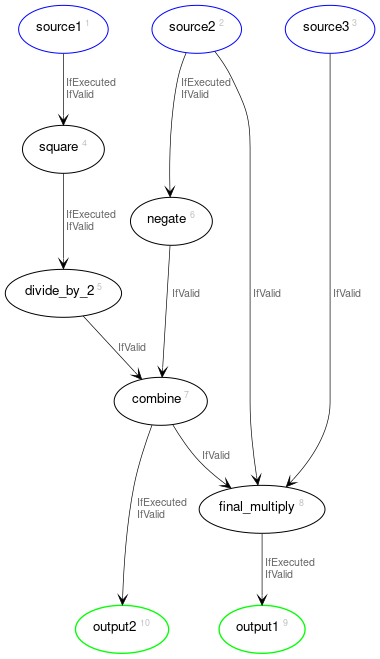

In [10]:
g = StreamGraph()

# Create source nodes
source1 = source!(g, :source1, Float64)
source2 = source!(g, :source2, Float64)
source3 = source!(g, :source3, Float64)

# Create compute nodes
square = op!(g, :square, Func{Float64}((exe, x) -> x^2, 0.0); out=Float64)
divide_by_2 = op!(g, :divide_by_2, Func{Float64}((exe, x) -> x / 2, 0.0); out=Float64)
negate = op!(g, :negate, Func{Float64}((exe, x) -> -x, 0.0); out=Float64)
combine = op!(g, :combine, Func{Tuple{Float64,Float64}}((exe, x, y) -> (x, y), (0.0, 0.0)); out=Tuple{Float64,Float64})
final_multiply = op!(g, :final_multiply, Func{Tuple{Float64,Float64}}((exe, tuple, src2, src3) -> tuple .* src2 .+ src3, (0.0, 0.0)); out=Tuple{Float64,Float64})

# Create sink nodes
output1 = sink!(g, :output1, Func((exe, x) -> println("output #1 at time $(time(exe)): $x")))
output2 = sink!(g, :output2, Func((exe, x) -> println("output #2 at time $(time(exe)): $x")))
# output2 = sink!(g, :output2, (exe, x) -> nothing)

# Create edges between nodes (define the computation graph)
bind!(g, source1, square)
bind!(g, square, divide_by_2)
bind!(g, source2, negate)
bind!(g, divide_by_2, combine, call_policies=[IfValid()])
bind!(g, negate, combine, call_policies=[IfValid()])
bind!(g, combine, final_multiply, call_policies=[IfValid()])
bind!(g, source2, final_multiply, call_policies=[IfValid()])
bind!(g, source3, final_multiply, call_policies=[IfValid()])
bind!(g, final_multiply, output1)
bind!(g, combine, output2)

exe = compile_historic_executor(DateTime, g, debug=!true)

adapters = [
    IterableAdapter(exe, source1, [
        (DateTime(2000, 1, 1, 0, 0, 1), 2.0),
        (DateTime(2000, 1, 1, 0, 0, 3), 4.0),
        (DateTime(2000, 1, 1, 0, 0, 5), 6.0)
    ]),
    IterableAdapter(exe, source2, [
        (DateTime(2000, 1, 1, 0, 0, 2), 10.0),
        (DateTime(2000, 1, 1, 0, 0, 4), 20.0),
        (DateTime(2000, 1, 1, 0, 0, 6), 30.0)
    ]),
    IterableAdapter(exe, source3, [
        (DateTime(2000, 1, 1, 0, 0, 2), 10.0),
        (DateTime(2000, 1, 1, 0, 0, 4), 20.0),
        (DateTime(2000, 1, 1, 0, 0, 6), 30.0)
    ])
]
run_simulation!(exe, adapters; start_time=DateTime(2000, 1, 1, 0, 0, 1), end_time=DateTime(2000, 1, 1, 0, 0, 6))

graphviz(exe.graph)

In [ ]:
# using BenchmarkTools
# dt = DateTime(2000, 1, 1, 0, 0, 2)
# @benchmark process!($exe, $src2_fn, $dt, 10.0) samples=500 evals=2